# Preprocessing

In this tutorial we will show how to construct a preprocessing pipeline to "prepare" your recording prior to spike sorting.
While some of the steps that we'll see are Neuropixels specific, most of the concepts can be applied to any probe device.

In [1]:
from pathlib import Path
import numpy as np

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.widgets as sw

import matplotlib.pyplot as plt

In [2]:
%matplotlib widget

## "Destriping" the raw traces

Neuropixels probes (and similar) have long shanks that can experience noise that appear as "stripes".
This section shows how to clean the signals and remove bad channels prior to spike sorting.

To demonstrate this, we are going to use some test datasets shared by Olivier Winter from IBL.

For more information, please refer to the IBL paper:

[Spike sorting pipeline for the International Brain Laboratory, ](https://figshare.com/articles/online_resource/Spike_sorting_pipeline_for_the_International_Brain_Laboratory/19705522/3)

In [6]:
base_folder = Path("/home/samuel/DataSpikeSorting/SI_tutorial_Cajal_2024/")

In [7]:
preprocessing_folder = base_folder / "dataset_preprocessing"
destriping_folder = preprocessing_folder / "destriping"
session = "8413c5c6-b42b-4ec6-b751-881a54413628"

In [9]:
ibl_data_cbin_file = [p for p in (destriping_folder / session).iterdir() if p.name.endswith(".ap.cbin")][0]

In [11]:
recording = se.read_cbin_ibl(cbin_file=ibl_data_cbin_file)
recording

CompressedBinaryIblExtractor: 384 channels - 30.0kHz - 1 segments - 30,000 samples - 1.00s 
                              int16 dtype - 21.97 MiB

Let's first take a look at the "raw" traces:

In [12]:
w = sw.plot_traces(recording, backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

We notice there are both some horizontal and vertical "stripes", plus some "patterns".

Although Neuropixels data have a hardware highpass filter (cutoff at 150Hz), there can be come leftover content from the LFP frequency band.

So let's first highpass the data and see how it looks:

In [13]:
recording_hp = spre.highpass_filter(recording)

# we can visualize multiple "layers" at the same time!
recording_layers = dict(
    raw=recording,
    highpass=recording_hp
)
w = sw.plot_traces(recording_layers, backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

Now the "patterns" are mainly gone, but we can still see some vertical artefacts and some horizontal lines.

While the vertical lines can be attributed to transient external noise, the horizontal ones are mainly due to a channel either being too silent ("dead") or too "noisy".

(In addition, on the top of the probe we can observe an area of faint activity. This could indicate that the recording area is not fully in the brain, which could happen when targeting surface area.)

### Phase shift

Neuropixels probes can record from 384 channels simultaneously, but the analog-to-digital converters (ADCs) of the probe are only 32!

**This means that channels are not sampled exactly at the same time!**

Within a sampling cicle (1/30kHz = 33$\mu$s), each ADC sweeps and samples a group of channels. While this misalignment could sound small, it could affect processing steps, such as common median reference.

The delay of each channel is automatically loaded as the `inter_sample_shift` property (when reading the data with the `read_spikeglx` or `read_openephys`), which tells what is the shift between 0 (beginning of the cycle) and 1 (end of the cycle) which each channel is sampled at by the ADC.

In [14]:
print(recording.get_property("inter_sample_shift")[:10])

[0.         0.         0.08333333 0.08333333 0.16666667 0.16666667
 0.25       0.25       0.33333333 0.33333333]


To correct for this shift, we can use the `spre.phase_sift()` function. This function internally uses a Fourier Transform to align each channel according to its sample shift.

In [15]:
recording_ps = spre.phase_shift(recording_hp)

In [16]:
recording_layers = dict(
    highpass=recording_hp,
    phase_shift=recording_ps
)
w = sw.plot_traces(recording_layers, time_range=[0.23, 0.25], backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

### Detect and remove bad channels

We still observe some horizontal bands, whcih suggests the presence of bad channels.

The `spre.detect_bad_channels()` function uses several strategies (including coherence along depth, PSD energy) to label channels as:
- "good"
- "dead": the signal is too weak
- "noisy": the signal is too strong
- "out": channels outside of the brain

In [17]:
bad_channel_ids, channel_labels = spre.detect_bad_channels(recording_ps)

In [18]:
labels, counts = np.unique(channel_labels, return_counts=True)

In [19]:
for label, count in zip(labels, counts):
    print(f"Found {count} channels with label {label}")

Found 9 channels with label dead
Found 375 channels with label good


Let's remove the "bad channels" with the `remove_channels` function:

In [20]:
recording_hp_rm = recording_hp.remove_channels(bad_channel_ids)
recording_ps_rm = recording_ps.remove_channels(bad_channel_ids)

### Denoise

Now that the channels are aligned, we can use some denoisers to remove these "common mode" noisy events. 

One option is to use the `spre.common_reference` function, which removes the median of the channel at each sample.
Another option, again developed by IBL, is to apply a highpass filter, but in the "space" dimension, i.e., across depth (`spre.highpass_spatial_filter`).

Let's apply these steps with and without `phase_shift` to see the difference:

In [21]:
recording_cmr_no_ps = spre.common_reference(recording_hp_rm)
recording_cmr_ps = spre.common_reference(recording_ps_rm)
recording_hps_no_ps = spre.highpass_spatial_filter(recording_hp_rm)
recording_hps_ps = spre.highpass_spatial_filter(recording_ps_rm)

In [22]:
recording_layers = dict(
    cmr_no_ps=recording_cmr_no_ps,
    cmr_ps=recording_cmr_ps,
    hps_no_ps=recording_hps_no_ps,
    hps_ps=recording_hps_ps,
)
w = sw.plot_traces(recording_layers, time_range=[0.23, 0.25], backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

Both CMR and highpass spatial filtering do a good job in removing the vertical stripes, but phase shift is necessary!

**Note**: the highpass spatial filter behaves better than CMR if the vertical stripes are not even across channels. However, its application might make the spiking activity weaker! 

## Remove artifacts due to optogenetics stimulation

In [23]:
dataset_artifacts =  preprocessing_folder / "artifacts"
recording_artifact_path = dataset_artifacts / "preprocessing_artifact_recording.zarr"
events_path = dataset_artifacts / "opto_stimulation_events.npy"

In [24]:
recording_artifacts = si.load_extractor(recording_artifact_path)
recording_artifacts

ZarrRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 90,000 samples - 3.00s - int16 dtype 
                        65.92 MiB

Note: this dataset is from Neuropixels 2.0, which, differently from 1.0, records a wideband signal without hardware filters.

Let's load the event information, which include the time, duration, and label for each stimulation event:

In [25]:
events_artifacts = np.load(events_path)
print(events_artifacts)
print(events_artifacts.dtype)

[(4864.70186667, 0.01, 'external_red_10mW')
 (4864.90186667, 0.01, 'external_red_10mW')
 (4865.10186667, 0.01, 'external_red_10mW')
 (4865.30186667, 0.01, 'external_red_10mW')
 (4865.50186667, 0.01, 'external_red_10mW')]
[('time', '<f8'), ('duration', '<f8'), ('label', '<U100')]


In [26]:
first_event_time = events_artifacts["time"][0]
time_range = [first_event_time - 0.02, first_event_time + 0.02]

In [27]:
recording_hp_artifacts = spre.highpass_filter(recording_artifacts)
recording_ps_artifacts = spre.phase_shift(recording_hp_artifacts)

**NOTE:** since both filtering and phase-shift are linear operations, the order doesn't matter!

In [28]:
recording_layers = dict(
    raw=recording_artifacts,
    highpass=recording_hp_artifacts,
    phase_shift=recording_ps_artifacts
)

w = sw.plot_traces(recording_layers, time_range=time_range, events=events_artifacts, backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

This recording displays some weird patterns of activity, which could affect the spike sorting results.

Could they be due to a localized added noisy source? Let's check the frequency content!

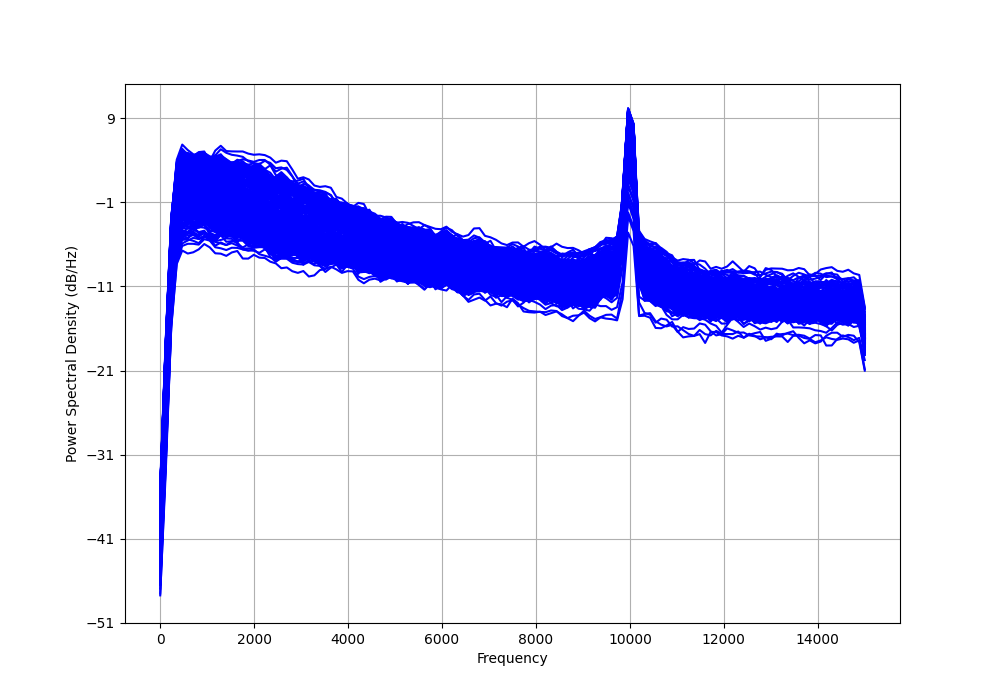

In [30]:
data_chunk = si.get_random_data_chunks(
    recording_ps_artifacts,
    num_chunks_per_segment=1,
    chunk_size=30000,
    seed=0
)

fig, ax = plt.subplots(figsize=(10, 7))
for tr in data_chunk.T:
    p, f = ax.psd(tr, Fs=recording_ps_artifacts.sampling_frequency, color="b")

Spotted! There is a nasty noise luckily localized at 10kHz. We can easily remove it with a notch filter (`spre.notch()` funciton):

In [31]:
recording_artifacts_notch = spre.notch_filter(recording_ps_artifacts, freq=10000, q=10)

In [32]:
data_chunk = si.get_random_data_chunks(
    recording_artifacts_notch,
    num_chunks_per_segment=1,
    chunk_size=30000,
    seed=0
)

for tr in data_chunk.T:
    p, f = ax.psd(tr, Fs=recording_artifacts_notch.sampling_frequency, color="r")

Now let's try to remove the stimulation artifacts with CMR:

In [33]:
recording_artifacts_cmr = spre.common_reference(recording_artifacts_notch)

In [34]:
recording_layers = dict(
    before_notch=recording_ps_artifacts,
    after_notch=recording_artifacts_notch,
    cmr_after_notch=recording_artifacts_cmr
)

w = sw.plot_traces(recording_layers, time_range=time_range, events=events_artifacts, backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

Unfortunately, CMR is not able to remove the artifacts entirely. Since we know the artifact times, we can blank out the signal in correspondence of the artifacts.

This will make the spike sorter life much easier, since it won't have to deal with this weird and large spiky signals:

In [35]:
# since the events_artifact only store the time of the rising edge, we need to fetch the times of the falling edge too:
rising_and_falling_times = []
for evt in events_artifacts:
    t_rising = evt["time"]
    t_falling = t_rising + evt["duration"]
    rising_and_falling_times.append(t_rising)
    rising_and_falling_times.append(t_falling)

artifact_sample_indices = np.searchsorted(
    recording_artifacts_cmr.get_times(),
    rising_and_falling_times
)

recording_rm_artifacts = spre.remove_artifacts(
    recording_artifacts_cmr,
    list_triggers=artifact_sample_indices,
    mode="zeros",
    ms_before=1.5,
    ms_after=1.5,
)

In [36]:
recording_layers = dict(
    cmr=recording_artifacts_cmr,
    remove=recording_rm_artifacts
)

w = sw.plot_traces(recording_layers, time_range=time_range, events=events_artifacts, backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

That's all for preprocessing! 

We have seen how (and why):

- preprocess Neuropixels-like recordings to "destripe"
- apply advanced tools to remove additional noisy sources and artifacts

There are several other preprocessing options. For a complete list, checkout our [dedicated documentation page](https://spikeinterface.readthedocs.io/en/latest/modules/preprocessing.html)!

Among these is motion correction, which is a very important preprocessing step and will be covered by the next tutorial.